In [1]:
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import numpy as np
from skimage.feature import hog
% matplotlib inline

In [2]:
cars = glob.glob('vehicles/*/*.png')
notcars = glob.glob('non-vehicles/*/*.png')

In [3]:
def data_look(car_list,notcar_list):
    data_dict = {}
    data_dict["n_cars"] = len(car_list)
    data_dict["n_notcars"] = len(notcar_list)
    image = cv2.imread(notcar_list[0])
    data_dict["image_shape"] = image.shape
    data_dict["data_type"] = image.dtype
    return data_dict

In [4]:
data_dict = data_look(cars,notcars)
print(data_dict)

{'data_type': dtype('uint8'), 'n_notcars': 8968, 'n_cars': 8792, 'image_shape': (64, 64, 3)}


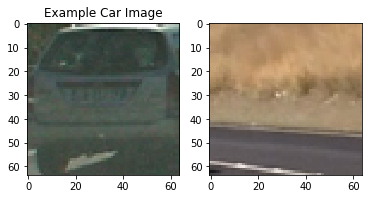

In [5]:
# choose two random indices
car_ind = np.random.randint(0,data_dict["n_cars"])
notcar_ind = np.random.randint(0,data_dict["n_notcars"])
# read the images
car_image = cv2.imread(cars[car_ind])
notcar_image = cv2.imread(notcars[notcar_ind])
car_image = cv2.cvtColor(car_image,cv2.COLOR_BGR2RGB)
notcar_image = cv2.cvtColor(notcar_image,cv2.COLOR_BGR2RGB)
# plot the image
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)

In [6]:
def get_hog_features(img,orient,pix_per_cell,cell_per_block,vis=True,feature_vec=True):
    if vis:
        features,hog_image = hog(img, orientations=orient,pixels_per_cell=(pix_per_cell,pix_per_cell)\
            ,cells_per_block=(cell_per_block,cell_per_block),visualise=vis,feature_vector=feature_vec,block_norm="L2-Hys")
        return features,hog_image
    else:
        features = hog(img,orientations=orient,pixels_per_cell=(pix_per_cell,pix_per_cell), \
                      cells_per_block=(cell_per_block,cell_per_block),visualise=vis,feature_vector=feature_vec,block_norm="L2-Hys")
        return features

In [7]:
def color_hist(img,nbins=32,bin_range=(0,256)):
    channel_1_hist = np.histogram(img[:,:,0],bins=32,range=bin_range)
    channel_2_hist = np.histogram(img[:,:,1],bins=32,range=bin_range)
    channel_3_hist = np.histogram(img[:,:,2],bins=32,range=bin_range)
    hist_feature = np.concatenate([channel_1_hist[0],channel_2_hist[0],channel_3_hist[0]])
    
    return hist_feature

In [8]:
def spatial_feature(img,size=(32,32)):
    # return a one dimensional feature vector
    features = cv2.resize(img,size).ravel()
   
    return features

In [9]:
# hog_channel can take values of 0, 1, 2, or "ALL"
# meaning that you extract HOG features from the first, second, third, or all color channels respectively.
def extract_features(imgs,cspace,spatial_size,nbins,bin_range,orient,pix_per_cell,cell_per_block,hog_channel,\
                     spatial_feat=True,hist_feat=True,hog_feat=True):
    
    feature_list = []
    for filename in imgs:
        features = []
        image = cv2.imread(filename)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
       
        # Apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
       
        # Compute spatial features if flag is set
        if spatial_feat == True:
            feature = spatial_feature(image,spatial_size)
            features.append(feature)
        
        # Compute histogram features if flag is set
        if hist_feat == True:
            feature = color_hist(image,nbins,bin_range).astype(np.float64)
            features.append(feature)
          
        
        # Compute HOG features if flag is set
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(image.shape[2]):
                    feature = get_hog_features(image[:,:,channel],orient,pix_per_cell,cell_per_block,vis=False)
                    hog_features.append(feature)
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(image[:,:,hog_channel],orient,pix_per_cell,cell_per_block,vis=False)
            features.append(hog_features)
        
        feature_list.append(np.concatenate(features))
        
    return feature_list

In [10]:
cspace = 'RGB'
spatial_size = (32,32)
nbins = 32
bin_range = (0,256)
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'

In [11]:
car_features = extract_features(cars, cspace, spatial_size, nbins, bin_range, orient\
             , pix_per_cell, cell_per_block, hog_channel)

In [12]:
notcar_features = extract_features(notcars,cspace, spatial_size, nbins, bin_range, orient\
             , pix_per_cell, cell_per_block, hog_channel)

In [13]:
X = np.vstack((car_features,notcar_features)).astype(np.float64)

In [14]:
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [15]:
from sklearn.preprocessing import StandardScaler

In [16]:
scaler = StandardScaler()

scaler.fit(X)

# data = (data - mean) / np.sqrt(var)
scaled_X = scaler.transform(X)

In [143]:
# Split data into randomized training and test sets
from sklearn.model_selection import train_test_split
rand_state = np.random.randint(0, 100)
X_train,X_test,y_train,y_test = train_test_split(scaled_X,y,test_size=0.2,random_state=rand_state)

In [144]:
from sklearn.svm import LinearSVC
# Use a linear SVC 
svc = LinearSVC()

In [145]:
svc.fit(X_train,y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [146]:
svc.score(X_test, y_test)

0.97663288288288286

In [18]:
from sklearn.externals import joblib

In [148]:
joblib.dump(svc, 'classifier.pkl') 

['classifier.pkl']

### check the score of the SVC

In [19]:
svc = joblib.load('classifier.pkl') 

In [20]:
print('SVC predicts: ', svc.predict(X_test[0:10]))
print('For these 10 labels:', y_test[0:10])

NameError: name 'X_test' is not defined

In [21]:
# take an image (not file name) as input
def single_img_features(img,cspace='RGB',spatial_size=(32,32),nbins=32,bin_range=(0,256),orient=9,\
        pix_per_cell=8, cell_per_block=2,hog_channel=0,spatial_feat=True,hist_feat=True,hog_feat=True):
    # Define an empty list to receive features
    features = []
    # Apply color conversion if other than 'RGB'
   
    if cspace != 'RGB':
        if cspace == 'HSV':
            cvt_img = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    else:
        cvt_img = img.copy()
   
    # Compute spatial features if flag is set
    if spatial_feat == True:
        feature = spatial_feature(cvt_img,spatial_size).astype(np.float64)
        features.append(feature)
        
    # Compute histogram features if flag is set
    if hist_feat == True:
        feature = color_hist(cvt_img,nbins,bin_range).astype(np.float64)
        features.append(feature)
    
    # Compute HOG features if flag is set
    if hog_feat == True:
        
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(cvt_img.shape[2]):
                feature = get_hog_features(img[:,:,channel],orient,pix_per_cell,cell_per_block,vis=False)
                hog_features.append(feature)
            hog_features = np.ravel(hog_features)
        
        else:
            hog_features = get_hog_features(img[:,:,hog_channel],orient,pix_per_cell,cell_per_block,vis=False)
     
        features.append(hog_features)
        
    return np.concatenate(features)

In [22]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    window_list = []
    
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    nx_pix_per_step = xy_window[0] * (1 - xy_overlap[0])
    ny_pix_per_step = xy_window[1] * (1 - xy_overlap[1])
    
    nx_window = np.int32((x_start_stop[1] - x_start_stop[0]) / nx_pix_per_step)
    ny_window = np.int32((y_start_stop[1] - y_start_stop[0]) / ny_pix_per_step)
    
    
    for i in range(nx_window-1):
        for j in range(ny_window-1):
            offset_x = i * nx_pix_per_step + x_start_stop[0]
            offset_y = j * ny_pix_per_step + y_start_stop[0]
            top_left = (np.int32(offset_x),np.int32(offset_y))
            bottom_right = (np.int32(offset_x + xy_window[0]), np.int32(offset_y + xy_window[1]))
            window_list.append((top_left,bottom_right))
    return window_list
    

In [97]:
def search_windows(img,windows,svc):
    hot = []
   
    for window in windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1],window[0][0]:window[1][0]],(64,64))
        
        feature = single_img_features(test_img,cspace='RGB',spatial_size=(32,32),nbins=32,bin_range=(0,256),orient=9,\
            pix_per_cell=8, cell_per_block=2,hog_channel='ALL',spatial_feat=True,hist_feat=True,hog_feat=True)
        
       
        # Scale extracted features to be fed to classifier
        feature = feature.reshape(1,-1)
        
        scaled_feature = scaler.transform(feature)
        
        prediction = svc.predict(scaled_feature)
        
        if prediction == 1:
          
            hot.append(window)
    
    return hot

In [98]:
def draw_boxes(image,bboxes,color=(0,0,255),thickness=6):
    img_copy = image.copy()
    for bbox in bboxes:
        cv2.rectangle(img_copy,bbox[0],bbox[1],color,thickness)
    return img_copy

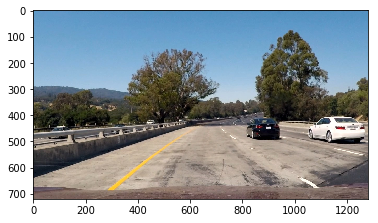

In [99]:
image = cv2.imread('test_images/test1.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [100]:
windows = slide_window(image,x_start_stop=[None,None],y_start_stop=[350,720],xy_window=(64,64),xy_overlap=(0.5,0.5))

In [101]:
hot_windows  = search_windows(image,windows,svc)

In [102]:
window_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thickness=6)  

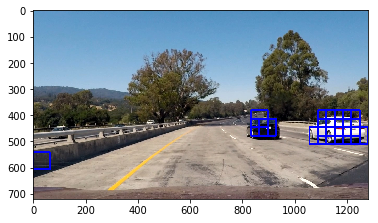

In [103]:
plt.imshow(window_img)

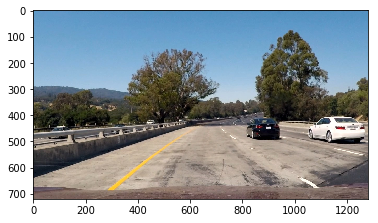

In [104]:
image = cv2.imread('test_images/test1.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [107]:
def find_cars(img,orient,pix_per_cell,cell_per_block,svc,cells_per_step,ystart,ystop):
    
    draw_img = img.copy()
    window = 64
    features = []

    img_tosearch = img[ystart:ystop,:,:]
    
    ch1 = img_tosearch[:,:,0]
    ch2 = img_tosearch[:,:,1]
    ch3 = img_tosearch[:,:,2]
    
    nx_blocks = (img_tosearch.shape[1] // pix_per_cell) - cell_per_block + 1
    ny_blocks = (img_tosearch.shape[0] // pix_per_cell) - cell_per_block + 1
    
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    
    nx_steps = (nx_blocks - nblocks_per_window) // cells_per_step 
    ny_steps = (ny_blocks - nblocks_per_window) // cells_per_step 
    
    a = 0
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1,orient,pix_per_cell,cell_per_block,vis=False,feature_vec=False)
    hog2 = get_hog_features(ch2,orient,pix_per_cell,cell_per_block,vis=False,feature_vec=False)
    hog3 = get_hog_features(ch3,orient,pix_per_cell,cell_per_block,vis=False,feature_vec=False)
    for x in range(nx_steps):
        for y in range(ny_steps):
            features = []
            ypos = y * cells_per_step
            xpos = x * cells_per_step
        
            
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell
            
            # Extract the image patch
            subimg = img_tosearch[ytop:ytop+window,xleft:xleft+window]
        
            # Get features
            feature = spatial_feature(subimg,spatial_size).astype(np.float64)
            features.append(feature)
        
            hist_features = color_hist(subimg,nbins,bin_range).astype(np.float64)
            features.append(hist_features)
            
            # Extract HOG for this patch
            hog1_feature = hog1[ypos:ypos+nblocks_per_window,xpos:xpos+nblocks_per_window].ravel()
            hog2_feature = hog2[ypos:ypos+nblocks_per_window,xpos:xpos+nblocks_per_window].ravel()
            hog3_feature = hog3[ypos:ypos+nblocks_per_window,xpos:xpos+nblocks_per_window].ravel()
            features.append(hog1_feature)
            features.append(hog2_feature)
            features.append(hog3_feature)
    
            features = np.hstack(features).reshape(1,-1)
            # Scale features
            scaled_feature = scaler.transform(features)
            predict = svc.predict(scaled_feature)
            
            
            if predict:
                cv2.rectangle(draw_img,(xleft, ytop+ystart),(xleft+window,ytop+window+ystart)\
                              ,(0,0,255),6) 
    return draw_img

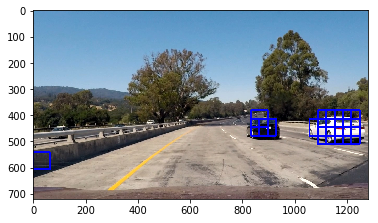

In [108]:
draw_img = find_cars(image,9,8,2,svc,4,350,720)

plt.imshow(draw_img)